In [1]:
from typing import List
import nltk
import os
import numpy as np
import pandas as pd
import string
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from enchant.checker import SpellChecker
# from nltk.stem import WordNetLemmatizer
import swifter
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import string
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("../final_data.csv",index_col=0)
df = df.reset_index()
printable = set(string.printable)#ascii chars
df['Text'] = df['Text'].swifter.apply(lambda s : ''.join(filter(lambda x: x in printable, str(s))))
lemmatizer = nltk.stem.WordNetLemmatizer()
df['Text'] = df['Text'].swifter.apply(lambda s : " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(str(s))]))
print(df.isna().sum())
df = df.dropna(axis='index')
count_vect = CountVectorizer(min_df=0.01)#max_features=1000
X_train_counts = count_vect.fit_transform(df['Text'])
count_vect_df = pd.DataFrame(X_train_counts.toarray(), columns=count_vect.get_feature_names())
X,y = count_vect_df,df['oh_label']
X.shape,y.shape
stop = set(stopwords.words('english'))
removed_cols = []
for col in X.columns:
    if col in stop:
        removed_cols.append(col)
X = X.drop(removed_cols,axis=1)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

Pandas Apply:   0%|          | 0/50000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/50000 [00:00<?, ?it/s]

index       0
Text        0
oh_label    0
dtype: int64


In [ ]:
# df.to_csv("cleaned.csv")

In [12]:
import tensorflow.compat.v1 as tf
import numpy as np
from typing import List
import math

tf.disable_v2_behavior()
eps = 0.2 #1e-2

def save_loss(data: list, filename: str):
    with open(filename, 'w') as f:
        for item in data:
            f.write("%s\n" % item)


class LogisticRegression:
    def __init__(self, X_train: np.ndarray, y_train: np.ndarray,x_test=None,y_test=None, epoch=1000, learning_rate=0.0001, batch_size=200):
        """
        weighted logistic regression using cross entropy loss function
        :param num_iter:
        :param batch_size: -1 means all
        """
        self.losses = []
        self.test_loss = []
        self.sess = tf.Session()
        lr = learning_rate
        learning_rate_tensor = tf.placeholder(tf.float64, shape=[])  # tensor for implement dynamic learning rate 
        features = X_train.shape[1]
        self.x = tf.placeholder(tf.float64, [None, features])
        y_train_variable = tf.placeholder(tf.float64, [None, 1])
        W = tf.Variable(tf.random.uniform([features, 1],dtype=tf.float64))
        b = tf.Variable(tf.random.uniform([1],dtype=tf.float64))
        self.y = tf.add(tf.matmul(self.x, W), b)
        w1_weight = (y_train == 1).sum()    # for imbalance data
        w0_weight = (y_train == 0).sum()
        # pos_weight multiple the 1 label => targets * -log(sigmoid(logits)) * pos_weight 
        loss = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(labels= y_train_variable, logits= tf.cast(self.y, tf.float64),pos_weight=tf.constant((w1_weight+w0_weight)/w1_weight, tf.float64)))
        update = tf.train.GradientDescentOptimizer(learning_rate = learning_rate_tensor).minimize(loss) 
        self.sess.run(tf.global_variables_initializer())
        rows_num = X_train.shape[0]
        for i in range(0, epoch * (rows_num//batch_size)):
            counter_step = i % (rows_num // batch_size)
            X_batch = X_train[counter_step * batch_size:min((counter_step + 1) * batch_size, rows_num)]
            Y_batch = y_train[counter_step * batch_size:min((counter_step + 1) * batch_size, rows_num)]
            Y_batch = Y_batch.reshape((Y_batch.size, 1))
            self.sess.run(update, feed_dict={self.x: X_batch, y_train_variable: Y_batch,learning_rate_tensor:lr})
            self.sess.run(loss, feed_dict={self.x: X_batch, y_train_variable: Y_batch,learning_rate_tensor:lr})
            loss_value = self.sess.run(loss, feed_dict={self.x: X_batch, y_train_variable: Y_batch,learning_rate_tensor:lr})
            loss_value_test = self.sess.run(loss, feed_dict={self.x:x_test, y_train_variable: y_test.reshape(y_test.size,1),learning_rate_tensor:lr})
            if i % (rows_num//batch_size) == 0:
                index = i//(rows_num//batch_size) 
                print(f"The learning rate is: {lr}")
                print(f"iteration {index}: loss value is: {loss_value}")
                self.losses.append(loss_value)
                self.test_loss.append(loss_value_test)
                if  self.losses[index] > self.losses[index-1]:  # check if the loss divergence
                    print("=====change learning rate=========")
                    lr = lr/10
        save_loss(self.losses, filename="train_error.txt")
        save_loss(self.test_loss, filename="test_error.txt")

    def predict(self, X_test, thr=0.5):
        predictions = self.sess.run(self.y, feed_dict={self.x: X_test})
        predictions[predictions >= thr] = 1
        predictions[predictions < thr] = 0
        return predictions


In [6]:
np.random.shuffle(X)

In [7]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [50]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((45000, 394), (5000, 394), (45000,), (5000,))

In [13]:
label_0_weight = y.size / (y == 0).sum()
label_1_weight = y.size / (y == 1).sum()
label_1_weight,label_0_weight

(2.940657531023937, 1.515289268721399)

In [ ]:
from sklearn.linear_model import SGDClassifier
logmodel = SGDClassifier(max_iter=100,loss='log', class_weight= {0: label_0_weight,1:label_1_weight}, random_state=42)
logmodel.fit(x_train,y_train)
predictions = logmodel.predict(x_test)
print(classification_report(y_test,predictions,zero_division=0))

In [129]:
logistic = LogisticRegression(x_train,y_train.values,x_test,y_test.values,epoch=20,learning_rate=0.1,batch_size=150)
predictions = logistic.predict(x_test)
print(classification_report(y_test, predictions,zero_division=0))

The learning rate is: 0.1
iteration 0: loss value is: 61.812302624218546
The learning rate is: 0.1
iteration 1: loss value is: 2.7641609092021535
The learning rate is: 0.1
iteration 2: loss value is: 1.6822946226275817
The learning rate is: 0.1
iteration 3: loss value is: 1.166243338437348
The learning rate is: 0.1
iteration 4: loss value is: 0.8690796976126022
The learning rate is: 0.1
iteration 5: loss value is: 0.6862190246422109
The learning rate is: 0.1
iteration 6: loss value is: 0.6216312953400823
The learning rate is: 0.1
iteration 7: loss value is: 0.5699115946706943
The learning rate is: 0.1
iteration 8: loss value is: 0.5880063413929263
=====change learning rate=========
The learning rate is: 0.01
iteration 9: loss value is: 0.5950390073199796
=====change learning rate=========
The learning rate is: 0.001
iteration 10: loss value is: 0.5971840802767289
=====change learning rate=========
The learning rate is: 0.0001
iteration 11: loss value is: 0.5974124102114153
=====change 

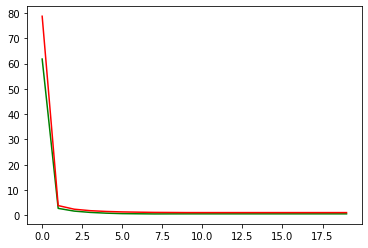

In [130]:
import matplotlib.pyplot as plt 
data_train = np.loadtxt("train_error.txt")
data_test = np.loadtxt("test_error.txt")
plt.plot(data_train,color='g')
plt.plot(data_test,color='r')

In [14]:
from typing import List

In [28]:
class MLP:
    """
    multi level perceptron implementation using tensorflow version 1
    """
        
    def __init__(self, x_train: np.ndarray, y_train, layers_sizes=(100,), learning_rate=0.1, epoch=50, batch_size=100):
        """
        Feed Foreword Neural network using Batch gradient decent optimizer
        :param layers_sizes: len of this list need to be greater than 1
        :param num_iter:
        :param print_step: print loss value every print_step echos
        """
        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=1)
        print(x_train.shape,x_test.shape,y_test.shape)
        self.sess = tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=4))
        self.losses = []
        self.test_loss = []
        lr = learning_rate
        learning_rate_tensor = tf.placeholder(tf.float64, shape=[])  # tensor for implement dynamic learning rate 
        rows_num, features = x_train.shape[0], x_train.shape[1]
        self.x = tf.placeholder(tf.float64, [None, features])
        y_train_variable = tf.placeholder(tf.float64, [None, 1])
        layers_sizes = [features] + list(layers_sizes) + [1]
        W, b = [], []
        for i, layer_size in enumerate(layers_sizes[1:]):
            W.append(tf.Variable(tf.random.uniform([layers_sizes[i], layer_size],dtype=tf.float64)))
            b.append(tf.Variable(tf.random.uniform([layer_size],dtype=tf.float64)))
        # ff
        prev_output = tf.nn.relu(tf.matmul(self.x, W[0]) + b[0])
        for layer_w, layer_b in zip(W[1:-1], b[1:-1]):
            print(prev_output)
            prev_output = tf.nn.relu(tf.add(tf.matmul(prev_output, layer_w), layer_b))
        print(prev_output)
        self.y = tf.add(tf.matmul(prev_output, W[-1]), b[-1])
        print(self.y)
        w1_weight = (y_train == 1).sum()    # for imbalance data
        w0_weight = (y_train == 0).sum()
        # pos_weight multiple the 1 label => targets * -log(sigmoid(logits)) * pos_weight 
        loss = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(labels=y_train_variable, logits= tf.cast(self.y, tf.float64),pos_weight=tf.constant((w1_weight+w0_weight)/w1_weight, tf.float64)))
        update = tf.train.GradientDescentOptimizer(learning_rate = learning_rate_tensor).minimize(loss) 
        self.sess.run(tf.global_variables_initializer())
        rows_num = x_train.shape[0]
        for i in range(0, epoch * (rows_num//batch_size)):
            counter_step = i % (rows_num // batch_size)
            X_batch = x_train[counter_step * batch_size:min((counter_step + 1) * batch_size, rows_num)]
            Y_batch = y_train[counter_step * batch_size:min((counter_step + 1) * batch_size, rows_num)]
            Y_batch = Y_batch.reshape((Y_batch.size, 1))
            self.sess.run(update, feed_dict={self.x: X_batch, y_train_variable: Y_batch,learning_rate_tensor:lr})
            loss_value = self.sess.run(loss, feed_dict={self.x: X_batch, y_train_variable: Y_batch,learning_rate_tensor:lr})
            loss_value_test = self.sess.run(loss, feed_dict={self.x:x_test, y_train_variable: y_test.reshape(y_test.size,1),learning_rate_tensor:lr})
            if i % (rows_num//batch_size) == 0:
                index = i//(rows_num//batch_size) 
                print(f"The learning rate is: {lr}")
                print(f"iteration {index}: loss value is: {loss_value}")
                self.losses.append(loss_value)
                self.test_loss.append(loss_value_test)
                if  self.losses[index] > self.losses[index-1]:  # check if the loss divergence
                    print("=====change learning rate=========")
                    lr = lr/10
        save_loss(self.losses, filename="MLP_train_error.txt")
        save_loss(self.test_loss, filename="MLP_test_error.txt")

    def predict(self, X_test, thr=0.5):
        predictions = self.sess.run(tf.nn.sigmoid(self.sess.run(self.y, feed_dict={self.x: X_test})))
        predictions[predictions >= thr] = 1
        predictions[predictions < thr] = 0
        return predictions



In [ ]:
logistic = MLP(x_train,y_train.values,layers_sizes=(200,100),epoch=140,batch_size=200,learning_rate=0.1)
predictions = logistic.predict(x_test)
print(classification_report(y_test, predictions,zero_division=0))

(40500, 394) (4500, 394) (4500,)
Tensor("Relu_18:0", shape=(?, 200), dtype=float64)
Tensor("Relu_19:0", shape=(?, 100), dtype=float64)
Tensor("Add_29:0", shape=(?, 1), dtype=float64)
The learning rate is: 0.1
iteration 0: loss value is: 4788580.263123191
The learning rate is: 0.1
iteration 1: loss value is: 1.1027967967606358
The learning rate is: 0.1
iteration 2: loss value is: 1.1025815617833887
The learning rate is: 0.1
iteration 3: loss value is: 1.1025537990922563
The learning rate is: 0.1
iteration 4: loss value is: 1.102553143810504
The learning rate is: 0.1
iteration 5: loss value is: 1.1025531436299227
The learning rate is: 0.1
iteration 6: loss value is: 1.1025531436316616
=====change learning rate=========
The learning rate is: 0.01
iteration 7: loss value is: 1.1023848287896305
The learning rate is: 0.01
iteration 8: loss value is: 1.1023138974716902
The learning rate is: 0.01
iteration 9: loss value is: 1.1022830263827246
The learning rate is: 0.01
iteration 10: loss value